<a href="https://colab.research.google.com/github/tomerlieber/Multi-Label-Emotion-Regression/blob/main/Emotion%20Regression%20using%20BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Detection
## Fine-tuning a BERT model for emotion detection
#### This part is modified from https://github.com/tomerlieber/Multi-Label-Emotion-Regression


### 1. Loading EmoBank Dataset

The dataset that we work on is called EmoBank, which comprises 10k sentences balancing multiple genres.

It's hosted on GitHub in this repo: https://github.com/JULIELab/EmoBank

In [1]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv('https://raw.githubusercontent.com/JULIELab/EmoBank/master/corpus/emobank.csv')

In [2]:
# null value

df[df.isnull().any(axis=1)]

,id,split,V,A,D,text
8412,easy_money_13624_13628,dev,2.78,2.89,2.78,NaN


In [3]:
# fill the null value using adjacent value

df.fillna(method='ffill', inplace=True)

df[df.isnull().any(axis=1)]

C:\Users\mrwho\AppData\Local\Temp\ipykernel_29636\2761690511.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


,id,split,V,A,D,text


In [4]:
# normalize valence and arousal value into -1 to 1

df['V'] = 0.5 * df['V'] - 1.5
df['A'] = 0.5 * df['A'] - 1.5

df

,id,split,V,A,D,text
0,110CYL068_1036_1079,train,0.000,0.000,3.20,"Remember what she said in my last letter? """
1,110CYL068_1079_1110,test,-0.100,0.050,2.80,If I wasn't working here.
2,110CYL068_1127_1130,train,0.000,0.000,3.00,".."""
3,110CYL068_1137_1188,train,0.220,0.000,3.22,Goodwill helps people get off of public assist...
4,110CYL068_1189_1328,train,0.275,0.135,3.46,Sherry learned through our Future Works class ...
...,...,...,...,...,...,...
10057,wwf12_4531_4624,train,0.000,0.250,3.00,Please let it be a constant reminder of all yo...
10058,wwf12_501_591,train,0.400,0.200,3.60,That’s why I want to extend my appreciation fo...
10059,wwf12_592_691,train,0.000,0.000,3.10,And why I’m writing you today to ask you to re...
10060,wwf12_702_921,train,0.165,0.220,3.44,"In fact, I want to urge you to strengthen your..."


In [5]:
df.describe()

,V,A,D
count,10062.000000,10062.000000,10062.000000
mean,-0.011655,0.020892,3.062763
std,0.174358,0.129771,0.209675
min,-0.900000,-0.600000,1.780000
25%,-0.100000,-0.055000,3.000000
50%,0.000000,0.000000,3.090000
75%,0.060000,0.100000,3.200000
max,0.800000,0.700000,4.200000


In [6]:
# Train,dev, test split
train_indexes = df.index[df['split'] == 'train'].tolist()
dev_indexes = df.index[df['split'] == 'dev'].tolist()
test_indexes = df.index[df['split'] == 'test'].tolist()

# Get the lists of sentences and their labels.
sentences = df.text.values
vad = df[['V', 'A', 'D']].values


### 2. Tokenization & Input Formatting

In [7]:
from transformers import BertTokenizer, BertModel, AdamW

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')

# Uncased means that the text has been lower cased before Word Piece
# tokenization, e.g., John Smith becomes john smith. The Uncased model also
# strips out any accent markers
bert_pretrained_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_pretrained_model_name)#, do_lower_case=True)

Loading BERT tokenizer...


C:\Users\mrwho\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
# Tokenize Dataset
# Perform one tokenization pass of the dataset in order to measure the maximum sentence length

def get_max_sentence_length(sentences):
  max_len = 0

  # For every sentence...
  for sent in sentences:

      # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
      input_ids = tokenizer.encode(sent, add_special_tokens=True)

      # Update the maximum sentence length.
      max_len = max(max_len, len(input_ids))

  return max_len

In [9]:
import torch

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

max_sentence_length = get_max_sentence_length(sentences)

# For every sentence...
for sentence in sentences:
  # `encode_plus` will:
  #   (1) Tokenize the sentence.
  #   (2) Prepend the `[CLS]` token to the start.
  #   (3) Append the `[SEP]` token to the end.
  #   (4) Map tokens to their IDs.
  #   (5) Pad or truncate the sentence to `max_length`
  #   (6) Create attention masks for [PAD] tokens.
  encoded_dict = tokenizer.encode_plus(
      sentence,                         # Sentence to encode.
      add_special_tokens = True,    # Add '[CLS]' and '[SEP]'
      max_length = max_sentence_length,             # Pad & truncate all sentences.
      truncation = True,            # Explicitely truncate sentences to max length.
      pad_to_max_length = True,
      return_attention_mask = True, # Construct attn. masks.
      return_tensors = 'pt',        # Return pytorch tensors.
      )
      
  # Add the encoded sentence to the list.    
  input_ids.append(encoded_dict['input_ids'])
  
  # And its attention mask (simply differentiates padding from non-padding).
  attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
outputs = torch.tensor(vad, dtype=torch.float32) # TODO: check if it's necessary


C:\Users\mrwho\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [10]:
from torch.utils.data import TensorDataset, Subset, DataLoader

# create an iterator for our dataset using the torch DataLoader class.
dataset = TensorDataset(input_ids, attention_masks, outputs)

train_dataset = Subset(dataset, train_indexes)
dev_dataset = Subset(dataset, dev_indexes)
test_dataset = Subset(dataset, test_indexes)

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            shuffle = True, # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
dev_dataloader = DataLoader(
            dev_dataset, # The validation samples.
            shuffle = False, # Default: Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset, # The test samples.
            shuffle = False, # Default: Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### 3. Train the Model

In [15]:
import torch.nn as nn

# Bert Model transformer with a sequence regression head on top (a linear
# layer on top of the pooled output).
class BertForSequenceRegression(nn.Module):
  def __init__(self, bert_pretrained_model_name, output_size):
    super(BertForSequenceRegression, self).__init__()
    self.bert = BertModel.from_pretrained(bert_pretrained_model_name,
                                          output_attentions = False,
                                          output_hidden_states = False)
    self.out = nn.Linear(self.bert.config.hidden_size, output_size)
    
  def forward(self, input_sentence, input_mask):
    last_hidden_states = self.bert(input_sentence, attention_mask=input_mask)[1]
    output = self.out(last_hidden_states)
    return output

model = BertForSequenceRegression(bert_pretrained_model_name, output_size=3)

# freeze some layers (top | middle | bottom):
bottom = range(2, 12)
middle = list(range(0,5))+list(range(7,12))
top = range(0, 10)

layersToFreeze = top # chose to keep the top layers for training
for i in layersToFreeze:
  print(i)
  for param in model.bert.encoder.layer[i].parameters():
    param.requires_grad = False

# Tell pytorch to run this model on the CPU
device = torch.device("cpu")
model.to(device)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

0
1
2
3
4
5
6
7
8
9


BertForSequenceRegression(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [16]:
# Training Loop

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [17]:
import torch.optim as optim

# Optimizer (ADAM is a fancy version of SGD) lr options: 2e-5
optimizer = optim.Adam(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 7 # set the epochs to 7

# Loss function
criterion = torch.nn.MSELoss()

# We'll store a number of quantities such as training loss and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
  # ========================================
  #               Training
  # ========================================
    
  # Perform one full pass over the training set.
  
  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
  print('Training...')

  # Measure how long the training epoch takes.
  t0 = time.time()

  # Reset the total loss for this epoch.
  total_train_loss = 0

  # Put the model into training mode.
  # Dropout layers behave differently during training vs. eval mode.
  model.train()

  # For each batch of training data...
  for step, batch in enumerate(train_dataloader):
    
    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using the 
    # `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # zero gradients
    optimizer.zero_grad()
    model.zero_grad()  

    # Perform a forward pass (evaluate the model on this training batch).
    output = model(b_input_ids, b_input_mask)

    # loss
    loss = criterion(output.view(-1), b_labels.view(-1))
      
    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_train_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

  # Calculate the average loss over all of the batches.
  avg_train_loss = total_train_loss / len(train_dataloader)

  # Measure how long this epoch took.
  training_time = format_time(time.time() - t0)

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(training_time))
  
  # ========================================
  #               Validation
  # ========================================
  # After the completion of each training epoch, measure our performance on
  # our validation set.

  print("")
  print("Running Validation...")

  t0 = time.time()

  model.eval()

  # Tracking variables 
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  # Evaluate data for one epoch
  for batch in dev_dataloader:

    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the GPU using 
    # the `to` method.
    #
    # `batch` contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: labels 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():
      
      # Perform a forward pass
      output = model(b_input_ids, b_input_mask)

    # loss
    loss = criterion(output.view(-1), b_labels.view(-1))

    # Accumulate the development loss.
    total_eval_loss += loss.item()

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(dev_dataloader)

  # Measure how long the development run took.
  validation_time = format_time(time.time() - t0)

  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))

  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch_i + 1,
          'Training Loss': avg_train_loss,
          'Training Time': training_time,
          'Valid. Loss': avg_val_loss,
          'Validation Time': validation_time
      })
  
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 7 ========
Training...
  Batch    40  of    252.    Elapsed: 0:03:48.
  Batch    80  of    252.    Elapsed: 0:07:46.
  Batch   120  of    252.    Elapsed: 0:11:51.
  Batch   160  of    252.    Elapsed: 0:15:57.
  Batch   200  of    252.    Elapsed: 0:20:05.
  Batch   240  of    252.    Elapsed: 0:24:16.

  Average training loss: 0.23
  Training epcoh took: 0:25:29

Running Validation...
  Validation Loss: 0.03
  Validation took: 0:01:45

======== Epoch 2 / 7 ========
Training...
  Batch    40  of    252.    Elapsed: 0:04:12.
  Batch    80  of    252.    Elapsed: 0:08:18.
  Batch   120  of    252.    Elapsed: 0:12:31.
  Batch   160  of    252.    Elapsed: 0:16:48.
  Batch   200  of    252.    Elapsed: 0:20:57.
  Batch   240  of    252.    Elapsed: 0:25:06.

  Average training loss: 0.03
  Training epcoh took: 0:26:20

Running Validation...
  Validation Loss: 0.02
  Validation took: 0:01:43

======== Epoch 3 / 7 ========
Training...
  Batch    40  of    252.    Elapse

In [25]:
# 预测

import torch

# 假设 `tokenizer` 是你在训练时使用的分词器
# 假设 `model` 是你已经训练好的模型

# 1. 文本预处理
def preprocess_text(text, tokenizer, max_length):
    # 使用与训练时相同的编码方法
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,  # 添加特殊标记 [CLS] 和 [SEP]
        max_length=max_length,    # 截断或填充到最大长度
        truncation=True,
        pad_to_max_length=True,
        return_attention_mask=True,  # 返回注意力掩码
        return_tensors='pt'          # 返回 PyTorch 张量
    )
    
    # 从字典中提取编码后的 ID 和注意力掩码
    input_ids = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask']
    
    return input_ids, attention_mask

# 2. 使用模型进行预测
def predict_vad(text, model, tokenizer, max_length=128):
    # 预处理文本
    input_ids, attention_mask = preprocess_text(text, tokenizer, max_length)
    
    # 将模型切换到评估模式
    model.eval()
    
    # 使用 GPU（如果可用）或 CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    
    # 关闭梯度计算（因为这是推理而不是训练）
    with torch.no_grad():
        # 前向传播，获取输出
        output = model(input_ids, attention_mask)
    
    # 解除与设备的绑定，并转换为 NumPy 数组或 Python 列表
    vad_values = output.cpu().numpy().flatten()
    
    return vad_values

# 示例：预测一个句子的 VAD 值
text = '''I feel so angry.'''
vad_values = predict_vad(text, model, tokenizer)

print("Predicted VAD values:", vad_values)


Predicted VAD values: [-0.6428524  0.2880371  2.849168 ]


C:\Users\mrwho\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [18]:
import pandas as pd

# Display floats with three decimal places.
pd.set_option('display.precision', 4)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Training Time,Valid. Loss,Validation Time
epoch,,,,
1,0.2283,0:25:29,0.0268,0:01:45
2,0.0257,0:26:20,0.0244,0:01:43
3,0.0233,0:26:29,0.0224,0:01:43
4,0.0216,0:26:47,0.0229,0:01:44
5,0.0204,0:26:32,0.0214,0:01:45
6,0.0190,0:26:16,0.0219,0:01:45
7,0.0179,0:26:50,0.0214,0:01:44


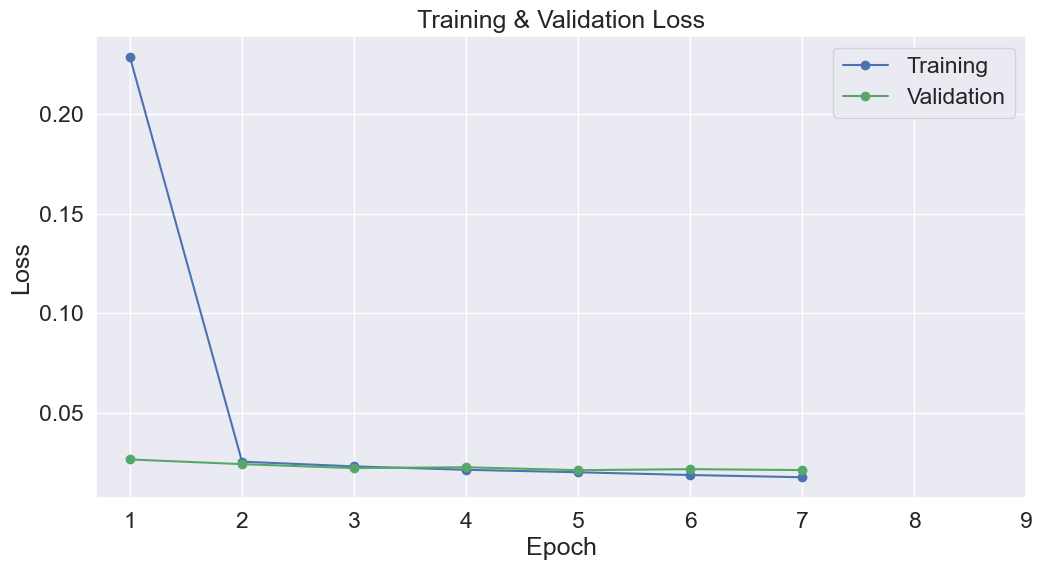

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9])

plt.show()

### 4. Performance On Test Set

In [26]:
# Prediction on test set

print('Predicting values for {:,} test sentences...'.format(len(test_dataloader.dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables
total_test_loss = 0

# Predict 
for batch in test_dataloader:

  # Add batch to GPU
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
    
    # Perform a forward pass
    output = model(b_input_ids, b_input_mask)

  # loss
  loss = criterion(output.view(-1), b_labels.view(-1))

  # Accumulate the development loss.
  total_test_loss += loss.item()

# Calculate the average loss over all of the batches.
avg_test_loss = total_test_loss / len(test_dataloader)

print(avg_test_loss)
print('    DONE.')

Predicting values for 1,000 test sentences...
0.021489752805791795
    DONE.


In [28]:
import torch

# save model parameters
torch.save(model.state_dict(), './model_dir/bert_for_emobank.pth')

# save tokenizer
tokenizer.save_pretrained('./model_dir')


('./model_dir\\tokenizer_config.json',
 './model_dir\\special_tokens_map.json',
 './model_dir\\vocab.txt',
 './model_dir\\added_tokens.json')

## Load pre-trained model

In [5]:
import torch
import torch.nn as nn

from transformers import BertTokenizer, BertModel
import torch

class BertForSequenceRegression(nn.Module):
  def __init__(self, bert_pretrained_model_name, output_size):
    super(BertForSequenceRegression, self).__init__()
    self.bert = BertModel.from_pretrained(bert_pretrained_model_name,
                                          output_attentions = False,
                                          output_hidden_states = False)
    self.out = nn.Linear(self.bert.config.hidden_size, output_size)
    
  def forward(self, input_sentence, input_mask):
    last_hidden_states = self.bert(input_sentence, attention_mask=input_mask)[1]
    output = self.out(last_hidden_states)
    return output

# Load Model and Tokenizer
def load_model_and_tokenizer(model_path, tokenizer_path, pretrained_model_name, output_size):
    # 加载 Tokenizer
    tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
    
    # 加载模型
    model = BertForSequenceRegression(pretrained_model_name, output_size=output_size)
    model.load_state_dict(torch.load(model_path))
    model.eval()  
    return model, tokenizer

# pre-process text
def preprocess_text(text, tokenizer, max_length=128):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,    
        max_length=max_length,     
        padding='max_length',       
        truncation=True,           
        return_tensors='pt',       
        return_attention_mask=True  
    )
    return inputs['input_ids'], inputs['attention_mask']

# predict emotion of text
def predict_emotion(text, model, tokenizer, device):
    input_ids, attention_mask = preprocess_text(text, tokenizer)
    
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    
    with torch.no_grad():
        output = model(input_ids, attention_mask)
    
    predicted_vad = output.cpu().numpy()[0]
    
    return predicted_vad

def main(text, model_path, tokenizer_path, pretrained_model_name, output_size):
    # Load Model and Tokenizer
    model, tokenizer = load_model_and_tokenizer(model_path, tokenizer_path, pretrained_model_name, output_size)
    
    # gpu check
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # emotion detection
    vad_values = predict_emotion(text, model, tokenizer, device)
    
    # print(f"Predicted VAD values: Valence: {vad_values[0]:.3f}, Arousal: {vad_values[1]:.3f}, Dominance: {vad_values[2]:.3f}")
    return vad_values

In [4]:

text = "Christmas won’t be Christmas without any presents, grumbled Jo, lying on the rug. It’s so dreadful to be poor! "

# load model and Tokenizer
model_path = './model_dir/bert_for_emobank.pth'
tokenizer_path = './model_dir'
pretrained_model_name = 'bert-base-uncased'
output_size = 3  # VAD 

values = main(text, model_path, tokenizer_path, pretrained_model_name, output_size)
print(values)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

[-0.01303284  0.13181265  3.1633368 ]


# Music Generation

In [8]:
from midiutil import MIDIFile

class TextToMusic:
    def __init__(self, valence, arousal):
        self.valence = valence
        self.arousal = arousal
        self.tempo = int(40 + (180 - 40) * (self.arousal - (-1)) / (1 - (-1)))   # Adjust tempo based on arousal
        self.volume = int(80 + (127 - 80) * (self.arousal - (-1)) / (1 - (-1)))  # Adjust volume based on arousal
        self.v_border = 0.1                                                      # The boundary between positive and negative
        self.timeSignature_numerator = 4 if valence > self.v_border else 3       # Select time signature based on valence
        self.instrument = 0 if arousal > self.v_border else 42                   # Select instrment based on valence
    
    def text_to_notes(self, text):
        """ Convert text to musical notes based on simple character mapping. """
        notes = []
        for char in text.lower():
            if 'a' <= char <= 'z':
                notes.append(ord(char) - ord('a'))  # MIDI note number for Middle C is 60
            elif char in ' ,.!?':                   # Map spaces and punctuation to rests
                notes.append('rest')
        # print(notes)
        return notes

    def apply_emotion_to_music(self, notes):
        """ Adjust notes based on the valence and scale changes. """
        if self.valence > self.v_border:
            scale = [0, 2, 4, 5, 7, 9, 11, 12, 14, 16, 17, 19, 21, 23]  # Major scale intervals
            # scale = [0, 2, 4, 7, 9, 12, 14, 16, 19, 21]
        else:
            scale = [0, 2, 3, 5, 7, 8, 10, 12, 14, 15, 17, 19, 20, 22]  # Minor scale intervals

        choose_scale = [60, 62, 69]
        
        adjusted_notes = []
        for n in notes:
            if n == 'rest':
                adjusted_notes.append('rest')
            else:
                adjusted_notes.append(60 + scale[n % len(scale)])  # Adjust notes based on scale 
        # print(adjusted_notes)
        return adjusted_notes

    def create_midi(self, notes, file_name="output.mid"):
        """ Generate a MIDI file from note data. """
        track = 0
        time = 0    # Start at the beginning of the track
        duration = 1    # Each note lasts 1 beat
#         volume = 100    # Volume level

        midi_file = MIDIFile(2)  # Create a 2 track MIDI file, 1 for melody, 1 for chords
        midi_file.addTimeSignature(track, time, self.timeSignature_numerator, 2, 24, 8)
        midi_file.addTempo(track, time, self.tempo)

        print(self.timeSignature_numerator)

        midi_file.addProgramChange(track, 0, time, self.instrument)
        
        root = 0
        
        # Add melody notes
        for note in notes:
            if note == 'rest':
                if time % self.timeSignature_numerator == 0:  # Add chords every 4 beats
                    self.add_chord(midi_file, track + 1, 60, time, duration, self.volume-40) # chord volumn smaller that melody
                    root = note
                time += 1  # Skip ahead one beat for a rest
                
            else:   # addNote(track, channel, pitch, time, duration, volume)
                midi_file.addNote(track, 0, note, time, duration, self.volume)
                if time % self.timeSignature_numerator == 0:  # Add chords every 4 beats
                    self.add_chord(midi_file, track + 1, note, time, duration, self.volume-40) # chord volumn smaller that melody
                    root = note
                    
                time += 1
                
            # print(note)
            
        with open(file_name, "wb") as output_file:
            midi_file.writeFile(output_file)

    def add_chord(self, midi_file, track, root_note, time, duration, volume):
        """ Add a chord based on the root note of the melody. """
        major = self.valence > self.v_border  # Select a major or minor chord based on valence

        root_low = root_note - 12
        third = root_low + (4 if major else 3)  # Major or minor third
        fifth = root_low + 7  # Perfect fifth
        
        # print(root_note, third, fifth)

        # Add root, third, and fifth notes for the chord
        midi_file.addNote(track, 0, root_low, time, duration * self.timeSignature_numerator, volume)  # Sustain chord for 4 beats
        midi_file.addNote(track, 0, third, time, duration * self.timeSignature_numerator, volume)
        midi_file.addNote(track, 0, fifth, time, duration * self.timeSignature_numerator, volume)

    def text_to_music(self, text, file_name="output.mid"):
        """ Full pipeline from text to music generation. """
        basic_notes = self.text_to_notes(text)
        emotion_notes = self.apply_emotion_to_music(basic_notes)
        self.create_midi(emotion_notes, file_name)



# Text2Music

In [9]:
# Text to Music with Emotion

text = '''It might seem crazy what I'm 'bout to say
Sunshine she's here, you can take a break
I'm a hot air balloon that could go to space
With the air, like I don't care, baby, by the way, huh
(Because I'm happy)
Clap along if you feel like a room without a roof
(Because I'm happy)
Clap along if you feel like happiness is the truth
(Because I'm happy)
Clap along if you know what happiness is to you
(Because I'm happy)
Clap along if you feel like that's what you wanna do'''

model_path = './model_dir/bert_for_emobank.pth'
tokenizer_path = './model_dir'
pretrained_model_name = 'bert-base-uncased'
output_size = 3  # VAD 

values = main(text, model_path, tokenizer_path, pretrained_model_name, output_size)
print(values)

music_generator = TextToMusic(values[0], values[1])
music_generator.text_to_music(text, "output_1.mid")

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

[0.26965013 0.21908334 3.232473  ]
4
